In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# 读取数据
data = pd.read_csv('./data/data_for_model.csv')
y_train = pd.read_csv('./data/label_for_model.csv')
# 通过调整数据类型，节省内存占用空间
data = reduce_mem_usage(data)

Memory usage of dataframe is 507151136.00 MB
Memory usage after optimization is: 143042816.00 MB
Decreased by 71.8%


In [4]:
from sklearn.model_selection import KFold
# 分离数据集，方便进行交叉验证
X_train = data.loc[data['sample']=='train', :].drop('sample', axis=1)
X_test = data.loc[data['sample']=='test', :].drop('sample', axis=1)
# y_train = y_train['isDefault']

# 5折交叉验证
folds = 5
seed = 2022
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [5]:
X_train.shape

(612742, 77)

In [6]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import xgboost as xgb
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)
# 数据封装
dtrain = xgb.DMatrix(X_train_split, y_train_split)
dvalid = xgb.DMatrix(X_val, y_val)

In [8]:
# 设置参数
params = {
            'booster': 'gbtree',    # 指定弱学习器的类型，默认gbtree
            'objective': 'binary:logistic',  # 学习目标：二元分类的逻辑回归，输出概率
            'learning_rate': 0.1,   # eta
            'eval_metric': 'auc',   # 验证数据的评估指标
            'min_child_weight': 1e-3,  # 默认值= 1，如果新分裂的节点的样本权重和小于min_child_weight则停止分裂 。
            'gamma': 0.1,       # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
            'max_depth': 6,    # 默认= 6，一棵树的最大深度。
            'reg_lambda': 0,   # 默认=1，L2正则化权重项。
            'reg_alpha': 0,    # 默认= 0，权重的L1正则化项
            'seed': 2022,      # 随机数种子
            'nthread': 8,      # 用于运行XGBoost的并行线程数，默认为最大可用线程数
            'verbosity': 0,    # 打印消息的详细程度。有效值为0（静默），1（警告），2（信息），3（调试）
}

"""使用训练集数据进行模型训练"""
evallist = [(dtrain,"train"),(dvalid,"valid")]
model = xgb.train(params, dtrain, num_boost_round=20000, evals=evallist, verbose_eval=100, early_stopping_rounds=200)

[0]	train-auc:0.70567	valid-auc:0.70105
[100]	train-auc:0.74693	valid-auc:0.72638
[200]	train-auc:0.76328	valid-auc:0.72849
[300]	train-auc:0.77591	valid-auc:0.72840
[400]	train-auc:0.78647	valid-auc:0.72845
[442]	train-auc:0.79005	valid-auc:0.72832


xgboost单模型在验证集上的AUC：0.7283171541841214


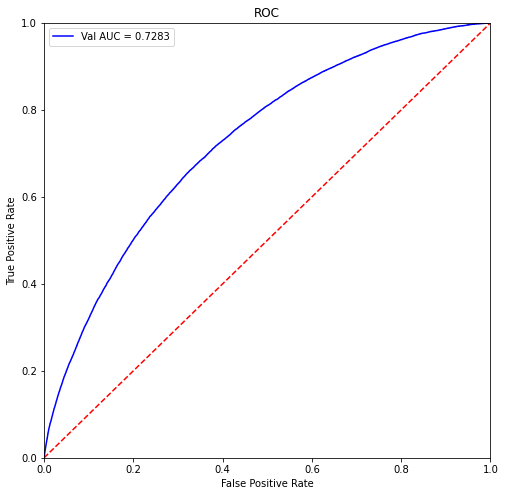

In [12]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

"""预测并计算roc的相关指标"""
val_pre_xgb = model.predict(dvalid)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_xgb)
roc_auc = metrics.auc(fpr, tpr)
print('xgboost单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [13]:
"""保存模型到本地"""
# 保存模型
import pickle
pickle.dump(model, open('./data/model_xgb_best.pkl', 'wb'))

In [35]:
test_data = X_test.copy()
test_data = test_data.fillna(0)
test_data.replace([np.inf, -np.inf], 0, inplace=True)

In [36]:
# 加载模型并获取测试结果
import pickle
dtest = xgb.DMatrix(test_data)
with open('./data/model_xgb_best.pkl','rb') as f:
    test_model = pickle.load(f)
    y_test_pred = test_model.predict(dtest)

In [37]:
id=np.arange(800000, 1000000)

In [38]:
df = pd.DataFrame(zip(id, y_test_pred), columns=['id', 'isDefault'])

In [39]:
df

,id,isDefault
0,800000,0.064854
1,800001,0.330316
2,800002,0.534374
3,800003,0.296969
4,800004,0.054087
...,...,...
199995,999995,0.141138
199996,999996,0.023009
199997,999997,0.159921
199998,999998,0.285454


In [40]:
df.to_csv('./data/out_xgb.csv', index=False)

<Figure size 864x432 with 0 Axes>

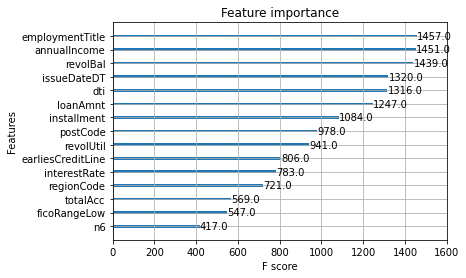

In [55]:
"""绘制特征重要性"""
from xgboost import plot_importance
# 显示重要特征，max_num_features 指定显示多少个特征
import pickle
import matplotlib.pyplot as plt
with open('./data/model_xgb_best.pkl','rb') as f:
    test_model = pickle.load(f)
    plt.figure(figsize=(12, 6))
    plot_importance(test_model, max_num_features = 15)
    plt.show()
    # 保存feature importance
    importance =test_model.get_score()
    feature_importance = pd.DataFrame({'feature_name':list(importance.keys()),'importance':list(importance.values())} )
    feature_importance.to_csv('./data/xgb_feature_importance.csv',index=False)

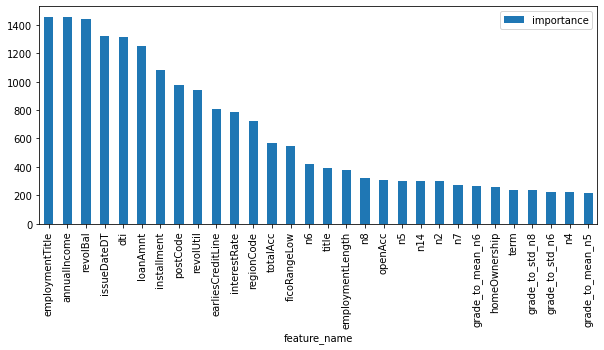

In [56]:
fea_i = pd.read_csv('./data/xgb_feature_importance.csv', index_col=0)
fea_i.sort_values(by='importance',inplace=True, ascending=False)
fea_i[:30].plot(kind="bar",figsize=(10,4))
plt.show()